Build and compare train a ConvNet for classification problems using pytorch


100%|██████████| 170498071/170498071 [00:10<00:00, 15826964.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/5], Train Loss: 4.7905, Train Acc: 0.5050, Val Loss: 1.3587, Val Acc: 0.5000
Epoch [2/5], Train Loss: 1.1908, Train Acc: 0.5800, Val Loss: 0.9041, Val Acc: 0.4800
Epoch [3/5], Train Loss: 0.5976, Train Acc: 0.6900, Val Loss: 0.9267, Val Acc: 0.5200
Epoch [4/5], Train Loss: 0.4840, Train Acc: 0.7650, Val Loss: 0.8310, Val Acc: 0.4200
Epoch [5/5], Train Loss: 0.4264, Train Acc: 0.7950, Val Loss: 1.0511, Val Acc: 0.5200


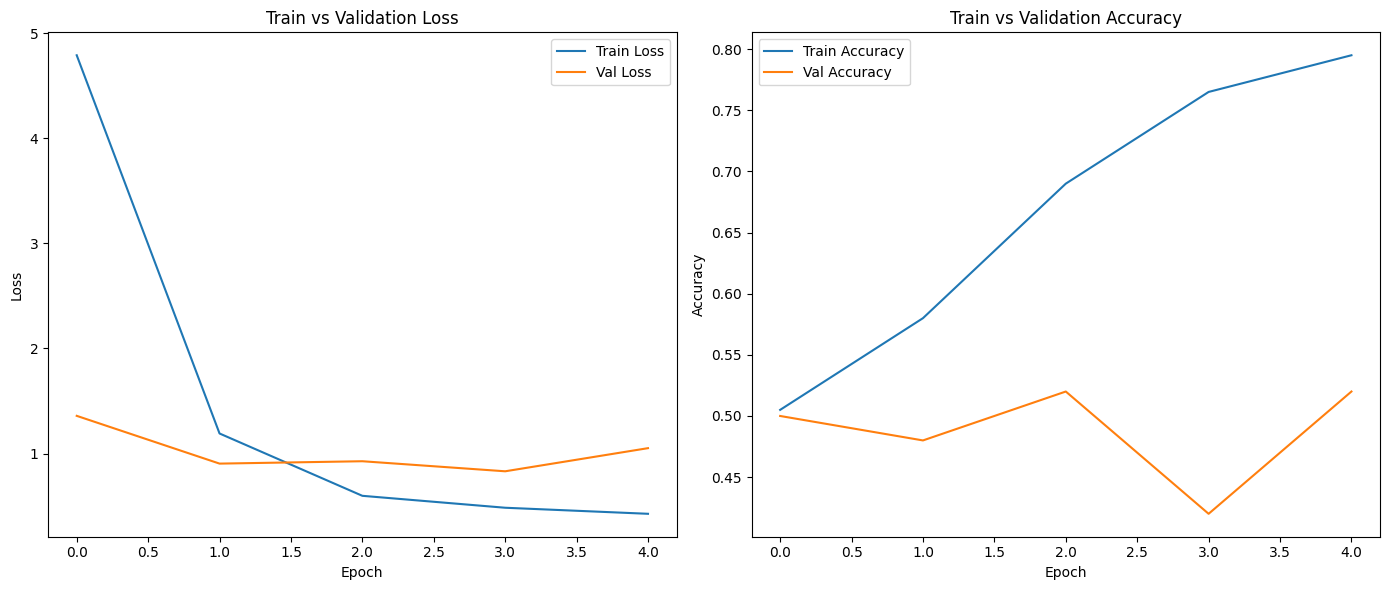

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt

# Step 1: Define transformations and load the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Download CIFAR-10 dataset and filter for cats (label 3) and dogs (label 5)
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter CIFAR-10 to only include cats and dogs, and limit the number of samples
def filter_and_reduce(dataset, limit=100):
    cats_dogs = []
    count = [0, 0]  # [cats, dogs]
    for img, label in dataset:
        if label == 3 and count[0] < limit // 2:
            cats_dogs.append((img, 0))  # 0 for cats
            count[0] += 1
        elif label == 5 and count[1] < limit // 2:
            cats_dogs.append((img, 1))  # 1 for dogs
            count[1] += 1
        if sum(count) >= limit:
            break
    return cats_dogs

train_data = filter_and_reduce(cifar10_train, limit=200)
val_data = filter_and_reduce(cifar10_test, limit=50)

train_loader = data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = data.DataLoader(dataset=val_data, batch_size=16, shuffle=False)

# Step 2: Define a simple ConvNet model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Step 3: Initialize the model, loss function, and optimizer
model = ConvNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model
num_epochs = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        labels = labels.view(-1, 1).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Step 5: Plot the results
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
